# ch7 利用AdaBoost元算法提高分类性能

做重要决定时，考虑多个专家的意见，类比到机器学习，这就是元方法的思路。

元方法也叫做集成方法，将不用的分类器组合起来。

元方法之一：boost方法。

## bagging方法与boosting方法

bagging方法，即自举汇集法(bootstrap aggregating)：从原始数据集选择S次后得到
S个数据集，新数据集和原始数据集大小相等。每次选择都是在原始数据集中随机选择一个样本替换所得到的数据集。替换意味着可以多次选择同一个样本。

bagging分类器权重相等，结果是基于所有分类器的加权求和结果。
boosting分类器权重不等，

boosting方法有多个版本，adaBoost是其中之一。


## AdaBoost

使用弱分类器和多个实例来构建一个强分类器，基于词，出现了adaboost算法。

adaBoost(adaptive boosting, adaBoost)，意为自适应booosting。运行过程：

训练数据集中的每个样本，赋予一个权重，构成权重向量D；
>初始权重全部相等。

训练出一个弱分类器，并计算该分类器的错误率，错误率计算公式：

$$
\epsilon=\frac{分类错误的样本个数}{样本总数}
$$

计算该分类器的权重值，公式为：
$$
\alpha=\frac{1}{2}ln(\frac{1-\epsilon}{\epsilon})
$$

>注：$\alpha$是为了从多个弱分类器中得到最终分类结果，adaBoost为每个分类器分配的权重值。

调整权重向量D：分类正确的样本，权重值降低，分类错误的权重，权重值上升。

如果样本分类正确：
$$
D_{i}^{(t+1)}=\frac{D_{i}^{(t)}e^{\alpha}}{sum(D)}
$$

如果样本分类错误：
$$
D_{i}^{(t+1)}=\frac{D_{i}^{(t)}e^{-\alpha}}{sum(D)}
$$
> 其中，t表示当前第t个分类器，i表示当前第i个样本。

进入下一次迭代。



## 7.3 基于单层决策树构建弱分类器

单层决策树：基于当个特征来做决策，而且只有一次分裂过程。也叫做决策树桩。


In [3]:
import numpy as np

In [4]:
def calc_cls_err(dataArr,labelArr,dim,value,rule,D):
    """
    按照第dim列，value值，来划分数据集。
    计算出错误率error，并与样本权重矩阵D相乘
    得到weightsError
    """
    # 转为np.mat
    dataArr,labelArr=np.mat(dataArr),np.mat(labelArr)
    # print("calc:np.shape(dataArr)",np.shape(dataArr))
    # print("calc:np.shape(labelArr)",np.shape(labelArr))
    # 分类误差
    errArr=np.ones( (dataArr.shape[0],1) )
    # 需要的一列；# 标签，用来计算err
    x=dataArr[:,dim];y=labelArr
    # 单层决策树，预测的结果
    retArr=np.ones( (dataArr.shape[0],1) )
    # 标签根据实际情况变化，设置变化规则
    # 按值分类数据集
    if rule == 'lt':
        retArr[x<=value] = -1.0    
    else:
        retArr[x>value] =  -1.0
    # 计算err
    errArr[retArr==labelArr]=0
    # print("cla:retArr",retArr.T)
    # print("cla:labelArr",labelArr.T)
    weightErr=np.dot(D.T,errArr)
    # 返回预测结果，错误率
    return retArr,weightErr

In [5]:
def createStump(dataArr,labelArr,D):
    # m*n;m*1
    dataMatrix = np.mat(dataArr); labelMat = np.mat(labelArr).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}; bestPredict = np.mat(np.zeros((m,1)))
    minError = np.inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for rule in ['lt', 'gt']: #go over less than and greater than
                value = (rangeMin + float(j) * stepSize)
                predictedVals,weightedError=calc_cls_err(dataMatrix,labelMat,i,value,rule,D)
                if weightedError < minError:
                    minError = weightedError
                    bestPredict = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = value
                    bestStump['ineq'] = rule
    return bestStump,minError,bestPredict

In [9]:
data=np.array([
    [1.,2.1],
    [2.,1.1],
    [1.3,1.],
    [1.,1.],
    [2.,1.]])
labe=[1.0,1.0,-1.0,-1.0,1.0]
d=np.ones((5,1))
createStump(data,labe,d)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 array([[1.]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

上述单层决策树的生成函数是决策树的简化版本，即弱学习器，也叫做弱分类算法。

接下来，使用多个弱分类器来构建完整的AdaBoost算法。

## 7.4 完整AdaBoost算法的实现

伪代码：
```
每一次迭代：
    使用createSingleTree()找到最佳的单层决策树、
    将最佳单层决策树加入到决策树数组
    计算该单层决策树的权重值$\alpha$
    计算新的权重向量D
    更新类别估计值
    如果错误率等于0.0，则退出迭代
```


In [10]:
def createBoostingTree(dataArr,labelArr,iter=40):
    # m*n,m*1
    dataArr=np.mat(dataArr);labelArr=np.mat(labelArr)
    m,n=np.shape(dataArr)
    finalPredict=np.zeros( (m,1) )
    # 初始化样本权重D
    D=np.ones((m,1))/m
    # tree
    boostTree=[]
    # 迭代
    for i in range(iter):
        bestSingleTree,err,predict=createStump(dataArr,labelArr,D)
        alpha=0.5*float( np.log( (1.0-err)/max(err,1e-16) ) )
        # print('alpha',alpha)
        bestSingleTree['alpha']=alpha
        boostTree.append(bestSingleTree)
        expon=np.multiply(-1 * alpha * labelArr.T,predict)   
        # print("expon",expon)
        D=np.multiply(D,np.exp(expon))
        D=D/D.sum()
        # print("D",D)
        finalPredict=finalPredict+alpha*predict
        finalErr = np.multiply(np.sign(finalPredict) != np.mat(labelArr).T,np.ones((m,1)))
        errRate=finalErr.sum()/m
        print("total error:",errRate)
        if errRate==0.0: break 
    return boostTree

In [11]:
# test
def loadSimpData():
    datMat = np.matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [12]:
# test
dataArr,labelArr=loadSimpData()
classArr=createBoostingTree(dataArr,labelArr,9)

total error: 0.2
total error: 0.2
total error: 0.0


## 7.6 示例：在一个难数据集上应用adaBoost

**加载数据**

In [13]:
def loadDataSet(fileName):      
    # general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [27]:
# train

dataArr,labelArr=loadDataSet("./horseColicTraining2.txt")
clsArr=createBoostingTree(dataArr,labelArr,10)

total error: 0.2842809364548495
total error: 0.2842809364548495
total error: 0.24749163879598662
total error: 0.24749163879598662
total error: 0.25418060200668896
total error: 0.2408026755852843
total error: 0.2408026755852843
total error: 0.22073578595317725
total error: 0.24749163879598662
total error: 0.23076923076923078


**单结点数据分类**

In [28]:
def stumpClassify(dataMatrix,dimen,value,rule):
    #just classify the data
    retArray = np.ones( (dataMatrix.shape[0],1) )
    if rule == 'lt':
        retArray[dataMatrix[:,dimen] <= value] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > value] = -1.0
    return retArray

**分类结果集成**

In [29]:
# 分类
def classify(datToClass,label,clsArr):
    dataMatrix = np.mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(clsArr)):
        classEst = stumpClassify(dataMatrix,clsArr[i]['dim'],\
                                 clsArr[i]['thresh'],\
                                 clsArr[i]['ineq'])
                                 #call stump classify
        aggClassEst += clsArr[i]['alpha']*classEst
        # print(aggClassEst)
    return np.sign(aggClassEst)

**模型测试**

In [30]:
# test
testArr,labels=loadDataSet("horseColicTest2.txt")
predictArr=classify(testArr,labels,clsArr)
errArr=np.ones( (len(labels),1) )
errCnt=errArr[predictArr!=np.mat(labels).T].sum()
errCnt

16.0

## 7.7 非均衡分类问题

先看几个分类器的性能度量指标：

1-混淆矩阵

|         |预测结果+1|预测结果-1|
| ----    | ----     | ----    |
|真实结果+1|   真正例TP|  伪反例FN   |
|真实结果-1|   伪正例FP|  真反例TN   |

正确率
$$
正确率=\frac{TP}{TP+FP}
$$
>正确率是预测的正样本中正确的正样本数占真实正样本总数的比例。

召回率
$$
召回率=\frac{TP}{TP+FN}
$$
>找回率是预测的正样本中正确的正样本数占预测出的正样本总数的比例。

ROC曲线

横轴是伪真例的比例，即FP(FP+TN)

纵轴是真正例的比例，即TP(TP+FN)

曲线下的面积AUC，给出的是分类器的平均性能值。完美分类器的AUC=1.0，
而随机猜测的AUC=0.5


In [31]:
import matplotlib.pyplot as plt
def plotROC(predStrengths, classLabels):   
    cur = (1.0,1.0) 
    #cursor
    ySum = 0.0 
    #variable to calculate AUC
    numPosClas = np.sum(np.array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()
    # get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ",ySum*xStep)

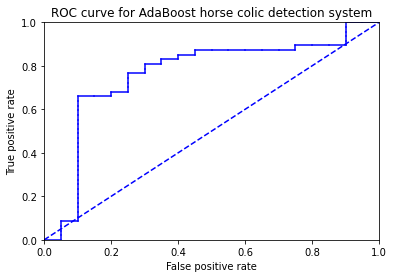

the Area Under the Curve is:  0.7627659574468083


In [32]:
 plotROC(predictArr.T,labels)